Datasets used: 
- `LiptonDataset` :<br>This dataset consists of two features, hair length and
work experience, and supposes a binary classifier that uses these
features to decide whether a given person should be hired.

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gfacts
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse
from aif360.sklearn.datasets import fetch_adult
import matplotlib.pyplot as plt
from sklearn import preprocessing

from IPython.display import Markdown, display

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


## Function to generate synthetic data used by Lipton et al. in arXiv:1711.07076

In [2]:
def generate_lipton(scale=True, num_pts=1000, seed=0):
    '''
    Synthetic data used by Lipton et al. in arXiv:1711.07076
    '''
    np.random.seed(seed)
    work_exp_m = np.random.poisson(31, size=num_pts) - np.random.normal(20, 0.2, size=num_pts)
    work_exp_f = np.random.poisson(25, size=num_pts) - np.random.normal(20, 0.2, size=num_pts)
    
    np.random.seed(seed+1)
    hair_len_m = 35 * np.random.beta(2, 7, size=num_pts)
    hair_len_f = 35 * np.random.beta(2, 2, size=num_pts)
    
    np.random.seed(seed+2)
    ym = np.random.uniform(size=num_pts) < 1 / (1 + np.exp(25.5 - 2.5*work_exp_m))
    yf = np.random.uniform(size=num_pts) < 1 / (1 + np.exp(25.5 - 2.5*work_exp_f))
    
    if scale: #scale the input attributes to zero mean and unit variance
        work_exp = np.concatenate((work_exp_m, work_exp_f))
        work_exp = preprocessing.scale(work_exp)
        work_exp_m = work_exp[:num_pts]
        work_exp_f = work_exp[num_pts:]
        hair_len = np.concatenate((hair_len_m, hair_len_f))
        hair_len = preprocessing.scale(hair_len)
        hair_len_m = hair_len[:num_pts]
        hair_len_f = hair_len[num_pts:]
    
    #combine the input attributes to create the input matrix
    Xm = np.stack((work_exp_m, hair_len_m), axis=1)
    Xf = np.stack((work_exp_f, hair_len_f), axis=1)
    columns = ['work_exp', 'hair_len']
    
    return Xm, Xf, ym, yf, columns

## Load Dataset

In [3]:
Xm, Xf, ym, yf, columns = generate_lipton()
Xm = pd.DataFrame(Xm,columns = columns)
Xf = pd.DataFrame(Xm,columns = columns)
Xm['labels'] = ym
Xf['labels'] = yf
Xm['labels'] = np.where((Xm['labels'] == True) , 1, 0)
Xf['labels'] = np.where((Xf['labels'] == True) , 1, 0)
Xm['gender'] = 'Male'
Xf['gender'] = 'Female'
df = pd.concat([Xm,Xf],ignore_index=True, sort=False)
df = df.sample(frac=1).reset_index(drop=True)
df['work_exp'], cut_bin = pd.qcut(df['work_exp'], q = 3, retbins = True,labels=['Small','Medium','Big'])
df['hair_len'], cut_bin = pd.qcut(df['hair_len'], q = 3, retbins = True,labels=['Short','Medium','Long'])


In [4]:
num_features = df._get_numeric_data().columns.to_list()
cate_features = df.select_dtypes(include=['category','object']).columns.to_list()

## Model training and test

In [5]:
X = df.drop('labels', axis=1)
y = df['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [6]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='labels')
model.predict(X_test.iloc[:100, :])

CPU times: total: 15.6 ms
Wall time: 22.7 ms


array([0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
       0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.])

In [7]:
positive_label = 1
negative_label = 0
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       391
           1       0.84      0.80      0.82       209

    accuracy                           0.88       600
   macro avg       0.87      0.86      0.86       600
weighted avg       0.88      0.88      0.88       600



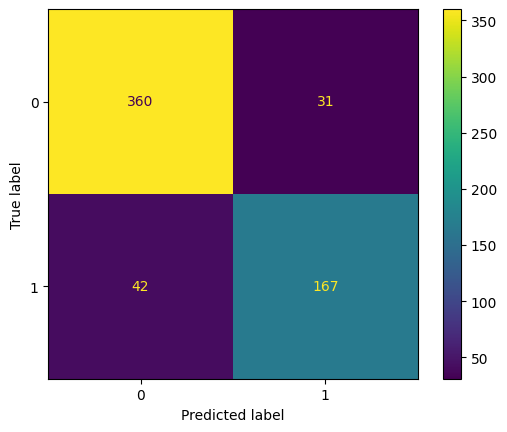

In [8]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [9]:
for col in cate_features:
    X_test[col] = X_test[col].astype('object')

In [16]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
     X_test,
     model=model,
     sensitive_attribute='gender',
     missing_subgroup_val="Unknown"
 )

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|██████████| 2/2 [00:00<00:00, 133.64it/s]

Computing the intersection between the frequent itemsets of each subgroup of the affected instances.



100%|██████████| 2/2 [00:00<?, ?it/s]

Computing all valid if-then pairs between the common frequent itemsets of each subgroup of the affected instances and the frequent itemsets of the unaffacted instances.



100%|██████████| 7/7 [00:00<00:00, 7022.27it/s]

Computing correctenesses for all valid if-thens.



100%|██████████| 19/19 [00:00<00:00, 71.86it/s]

Number of if-thens: 19


In [17]:
 ### Uncomment if you wish to save rules object on disk

import dill

with open("rulesAdultFairTest.data", "wb") as outf:
    dill.dump(rules_by_if, outf)

In [10]:

# import dill

# with open("rulesAdultFairTest.data", "rb") as inf:
#     rules_by_if = dill.load(inf)


In [11]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["Male"][1][0][1]-e[1]["Female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If work_exp = Small:
	Subgroup 'Female', 31.1258% covered
		Make work_exp = Big with correctness 0.0000%.
		Make work_exp = Medium with correctness 0.0000%.
	Subgroup 'Male', 100.0000% covered
		Make work_exp = Big with correctness 100.0000%.
		Make work_exp = Medium with correctness 100.0000%.
If work_exp = Small, hair_len = Long:
	Subgroup 'Female', 11.9205% covered
		Make work_exp = Medium with correctness 0.0000%.
	Subgroup 'Male', 34.0000% covered
		Make work_exp = Medium with correctness 100.0000%.
If hair_len = Short, work_exp = Small:
	Subgroup 'Female', 10.5960% covered
		Make hair_len = Long, work_exp = Big with correctness 0.0000%.
		Make hair_len = Medium, work_exp = Medium with correctness 0.0000%.
		Make work_exp = Big with correctness 0.0000%.
		Make hair_len = Medium, work_exp = Big with correctness 0.0000%.
		Make work_exp = Medium with correctness 0.0000%.
	Subgroup 'Male', 30.0000% covered
		Make hair_len = Long, work_exp = Big with correctness 100.0000%.
		Make hair

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [12]:
feature_weights = {"hair_len": 1, "work_exp": 1}
comparators = gfacts.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

In [13]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 10
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs
))

If hair_len = Short, work_exp = Small:
	Subgroup 'Female', 10.5960% covered out of 1000
		Make hair_len = Long, work_exp = Big with correctness 0.0000%.
		Make hair_len = Medium, work_exp = Medium with correctness 0.0000%.
		Make work_exp = Big with correctness 0.0000%.
		Make hair_len = Medium, work_exp = Big with correctness 0.0000%.
		Make work_exp = Medium with correctness 0.0000%.
		Aggregate cost of the above recourses = 0.0
	Subgroup 'Male', 30.0000% covered out of 1000
		Make hair_len = Long, work_exp = Big with correctness 100.0000%.
		Make hair_len = Medium, work_exp = Medium with correctness 100.0000%.
		Make work_exp = Big with correctness 100.0000%.
		Make hair_len = Medium, work_exp = Big with correctness 100.0000%.
		Make work_exp = Medium with correctness 100.0000%.
		Aggregate cost of the above recourses = 1.6
If hair_len = Medium, work_exp = Small:
	Subgroup 'Female', 8.6093% covered out of 1000
		Make hair_len = Long, work_exp = Big with correctness 0.0000%.
		Make w

## Minimum cost above threshold

In [17]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs
))

If work_exp = Small:
	Subgroup 'Female', 31.1258% covered out of 1000
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'Male', 100.0000% covered out of 1000
		Make work_exp = Big with correctness 100.0000%.
		Make work_exp = Medium with correctness 100.0000%.
		Aggregate cost of the above recourses = 1.0
If work_exp = Small, hair_len = Long:
	Subgroup 'Female', 11.9205% covered out of 1000
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'Male', 34.0000% covered out of 1000
		Make work_exp = Medium with correctness 100.0000%.
		Aggregate cost of the above recourses = 1.0
If hair_len = Short, work_exp = Small:
	Subgroup 'Female', 10.5960% covered out of 1000
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'Male', 30.0000% covered out of 1000
		Make hair_len = Long, work_exp = Big with correctness 100.0000%.
		Make hair_len = Medium, work_exp = Medium with correctne

## Cost above threshold

In [19]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="total-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs
))

If work_exp = Small:
	Subgroup 'Female', 31.1258% covered out of 1000
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'Male', 100.0000% covered out of 1000
		Make work_exp = Big with correctness 100.0000%.
		Make work_exp = Medium with correctness 100.0000%.
		Aggregate cost of the above recourses = 2.0
If work_exp = Small, hair_len = Long:
	Subgroup 'Female', 11.9205% covered out of 1000
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'Male', 34.0000% covered out of 1000
		Make work_exp = Medium with correctness 100.0000%.
		Aggregate cost of the above recourses = 1.0
If hair_len = Short, work_exp = Small:
	Subgroup 'Female', 10.5960% covered out of 1000
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Subgroup 'Male', 30.0000% covered out of 1000
		Make hair_len = Long, work_exp = Big with correctness 100.0000%.
		Make hair_len = Medium, work_exp = Medium with correctne

## Number above threshold

In [21]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (X["gender"] == sg).sum() for sg in X["gender"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs
))

If hair_len = Short, work_exp = Small:
	Subgroup 'Female', 10.5960% covered out of 1000
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.0
	Subgroup 'Male', 30.0000% covered out of 1000
		Make hair_len = Long, work_exp = Big with correctness 100.0000%.
		Make hair_len = Medium, work_exp = Medium with correctness 100.0000%.
		Make work_exp = Big with correctness 100.0000%.
		Make hair_len = Medium, work_exp = Big with correctness 100.0000%.
		Make work_exp = Medium with correctness 100.0000%.
		Aggregate cost of the above recourses = 5.0
If hair_len = Medium, work_exp = Small:
	Subgroup 'Female', 8.6093% covered out of 1000
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.0
	Subgroup 'Male', 36.0000% covered out of 1000
		Make hair_len = Long, work_exp = Big with correctness 100.0000%.
		Make work_exp = Medium with correctness 100.0000%.
		Make hair_len = Short, work_exp = Big with correctness 100.0000%.
		Make work_exp = Big wit